## 1. Load raw data

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

In [2]:
df_daily_rent = pd.read_csv("../data/raw/daily_rent_detail.csv")
df_weather = pd.read_csv("../data/raw/weather.csv")

C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\1505384709.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_daily_rent = pd.read_csv("../data/raw/daily_rent_detail.csv")


In [71]:
df_daily_rent.shape

(16086672, 13)

# 2. Data cleaning

In [3]:
df_daily_rent_copy = df_daily_rent.copy()
df_weather_copy = df_weather.copy()

In [4]:
df_daily_rent_copy.shape

(16086672, 13)

In [5]:
# 1. Calculate amount & percent
check_nan = df_daily_rent_copy.isna().sum()
check_nan_percent = df_daily_rent_copy.isna().mean() * 100

# 2. Merge to data frame
# axis=1 merge by col
nan_summary = pd.concat([check_nan, check_nan_percent], axis=1)

# 3. Set col name
nan_summary.columns = ["count", "percent"]

# 4. Display if nan amount > 0
display(nan_summary[nan_summary["count"] > 0])

,count,percent
start_station_name,1450150,9.014605
start_station_id,1450150,9.014605
end_station_name,1558268,9.686702
end_station_id,1558917,9.690737
start_lat,10,0.000062
start_lng,10,0.000062
end_lat,25929,0.161183
end_lng,25929,0.161183


In [6]:
df_daily_rent_copy = df_daily_rent_copy.dropna()

In [7]:
# Check duplicated ride_id 
check_duplicates = df_daily_rent_copy.duplicated(subset="ride_id").sum()
print("Duplicated ride_id amount:", check_duplicates)

# Drop duplicated ride_id 
df_daily_rent_copy = df_daily_rent_copy.drop_duplicates(subset="ride_id", keep='first')

Duplicated ride_id amount: 94


In [8]:
df_daily_rent_copy.shape

(13928123, 13)

In [ ]:
duplicate_count_rider_id = df_daily_rent_copy.duplicated(subset=['ride_id']).sum()
print(f"Number of duplicate ride_id: {duplicate_count_rider_id}")

df_daily_rent_copy.shape
print(f"Total number of data rows: {len(df_daily_rent_copy)}")

Số lượng dòng bị trùng theo ride_id sau khi loại bỏ: 0
Tổng số dòng dữ liệu: 13928123


In [10]:
# 1. Calculate amount & percent
check_nan = df_daily_rent_copy.isna().sum()
check_nan_percent = df_daily_rent_copy.isna().mean() * 100

# 2. Merge to data frame
# axis=1 merge by col
nan_summary = pd.concat([check_nan, check_nan_percent], axis=1)

# 3. Set col name
nan_summary.columns = ["count", "percent"]

# 4. Display if nan amount > 0
display(nan_summary[nan_summary["count"] > 0])

,count,percent


In [11]:
# Drop nan
df_daily_rent_copy = df_daily_rent_copy.dropna()

In [12]:
df_daily_rent_copy.shape

(13928123, 13)

# 3. Data Integration

In [13]:
# Retrive necessary features from raw data
df_weather_needs = df_weather_copy[["datetime","icon"]].copy()
df_daily_rent_needs = df_daily_rent_copy[["started_at"]].copy()

# Create necessary data by merging from raw data 
df_temp = pd.to_datetime(df_daily_rent_needs["started_at"], format="mixed")
df_daily_rent_needs["datetime"] = df_temp.dt.strftime("%Y-%m-%d")
df_final = pd.merge(df_daily_rent_needs, df_weather_needs, how="left", on="datetime")

In [ ]:
import pandas as pd

# 1. Extract the necessary columns
df_weather_needs = df_weather_copy[["datetime", "icon"]].copy()
df_daily_rent_needs = df_daily_rent_copy[["ride_id", "started_at"]].copy()

# 2. CREATE THE 'datetime' COLUMN FOR THE RENT TABLE
# Convert 'started_at' to datetime, then take only the date part (YYYY-MM-DD) to match the weather file
df_daily_rent_needs['datetime'] = pd.to_datetime(df_daily_rent_needs['started_at'], format='mixed').dt.strftime('%Y-%m-%d')

# Make sure the Weather table is also in string format YYYY-MM-DD for an exact match
df_weather_needs['datetime'] = pd.to_datetime(df_weather_needs['datetime']).dt.strftime('%Y-%m-%d')

# 3. Merge THE TWO DATAFRAMES ON 'datetime'
df_final = pd.merge(df_daily_rent_needs, df_weather_needs, how="left", on="datetime")

# Check the result
print(df_final.head())

            ride_id           started_at    datetime               icon
0  946D42AD89539210  2020-05-30 17:25:29  2020-05-30               rain
1  CC46FAAB662B8613  2020-05-09 14:42:04  2020-05-09  partly-cloudy-day
2  72F00B2FB833D6ED  2020-05-24 17:27:19  2020-05-24             cloudy
3  4DFBE6AED989DF35  2020-05-27 15:29:52  2020-05-27  partly-cloudy-day
4  1AAFE6B4331AB9DF  2020-05-31 14:06:03  2020-05-31  partly-cloudy-day


In [15]:
# Save to a new file to avoid permission issues
df_final.to_csv("../data/raw/final.csv", index=False)

In [16]:
df_final = df_final.drop_duplicates(subset=['ride_id'], keep='first')

# 4. Feature engineering

In [17]:
df_raw = pd.read_csv("../data/raw/final.csv")

In [139]:
df = df_raw.copy()

In [140]:
# Create time from started_at
df_temp = pd.to_datetime(df["started_at"], format="mixed")
df["hour"] = df_temp.dt.strftime("%H").astype(int)
df["time"] = pd.DataFrame(df_temp.dt.strftime("%H:%M"))
df["dow"] = pd.DataFrame(df_temp.dt.day_name())

In [141]:
# Group by datetime & hour
df_hourly = df.groupby(["datetime", "hour"]).agg({"icon": "first"}).reset_index()

# Create usage col by counting 
counts = df.groupby(["datetime", "hour"]).size().reset_index(name="usage")

# Merge usage col into df_hourly
df_hourly = df_hourly.merge(counts, on=["datetime", "hour"])
df_hourly["hour"] = df_hourly["hour"].astype(int)
df_hourly.head()

,datetime,hour,icon,usage
0,2020-05-01,0,rain,9
1,2020-05-01,2,rain,4
2,2020-05-01,3,rain,1
3,2020-05-01,4,rain,4
4,2020-05-01,5,rain,10


In [142]:
# Create time-series dataframe for merging to create usage by hour in day
unique_dates = df["datetime"].unique()
df_date = pd.DataFrame({"datetime": unique_dates})

full_time_range = pd.date_range("00:00", "23:59", freq="min").strftime("%H").astype(int)
df_time = pd.DataFrame({"hour": full_time_range})

df_template = df_date.merge(df_time, how="cross")
df_template = df_template.drop_duplicates(["datetime","hour"]).reindex()

df_template.head()

,datetime,hour
0,2020-05-30,0
60,2020-05-30,1
120,2020-05-30,2
180,2020-05-30,3
240,2020-05-30,4


In [143]:
# Create new dataframe contain datetime, time, icon, usage (by hour in day) by merging
df_hourly["datetime"] = pd.to_datetime(df_hourly["datetime"])
df_template["datetime"] = pd.to_datetime(df_template["datetime"])

df= df_template.merge(df_hourly, on=["datetime","hour"], how="left").sort_values(["datetime","hour"])
df.head()

,datetime,hour,icon,usage
336,2020-05-01,0,rain,9.0
337,2020-05-01,1,NaN,NaN
338,2020-05-01,2,rain,4.0
339,2020-05-01,3,rain,1.0
340,2020-05-01,4,rain,4.0


In [144]:
# Create weather dict by datetime for mapping NaN values
df_weather_map = df_hourly[["datetime", "icon"]].drop_duplicates(subset="datetime").set_index("datetime")["icon"]
df_weather_map.head()

datetime
2020-05-01                 rain
2020-05-02    partly-cloudy-day
2020-05-03                 rain
2020-05-04                 rain
2020-05-05                 rain
Name: icon, dtype: object

In [145]:
# Fill NaN icon by mapping
df["icon"] = df["datetime"].map(df_weather_map)

# Fill NaN usage by zero
df["usage"] = df["usage"].fillna(0)
df.head()

,datetime,hour,icon,usage
336,2020-05-01,0,rain,9.0
337,2020-05-01,1,rain,0.0
338,2020-05-01,2,rain,4.0
339,2020-05-01,3,rain,1.0
340,2020-05-01,4,rain,4.0


In [146]:
# Create usage_lag_1h, usage_lag_24h from usage
# usage_lag_1h = usage 1 hour before
df["usage_lag_1h"] = df["usage"].shift(1).fillna(0)
df["usage_lag_24h"] = df["usage"].shift(24).fillna(0)

In [147]:
# Create month, day, dow from datetime 
df_temp = pd.to_datetime(df["datetime"], format="mixed")
df["month"] = df_temp.dt.month.astype(int)
df["day"] = df_temp.dt.day.astype(int)
df["dow"] = df_temp.dt.day_name().str.lower().str[:3]

In [148]:
season_map = {
    1: 'winter', 2: 'spring', 3: 'spring', 4: 'spring',
    5: 'summer', 6: 'summer', 7: 'summer',
    8: 'autumn', 9: 'autumn', 10: 'autumn',
    11: 'winter', 12: 'winter'
}

df["season"] = df_temp.dt.month.map(season_map)

In [ ]:
# Create weekend 
df["weekend"] = df["dow"].isin(["sat", "sun"]).astype(int)

In [ ]:
# Transform datetime to date_since
df["datetime"] = pd.to_datetime(df["datetime"], format="mixed")
df["date_since"] = (df["datetime"] - df["datetime"].min()).dt.days
df = df.drop(columns="datetime")
df = df[["date_since", "month", "day", "hour", "dow", "weekend", "season", "icon", "usage_lag_1h", "usage_lag_24h", "usage"]].reindex()

,date_since,month,day,hour,dow,weekend,season,icon,usage_lag_1h,usage_lag_24h,usage
336,0,5,1,0,fri,0,summer,rain,0.0,0.0,9.0
337,0,5,1,1,fri,0,summer,rain,9.0,0.0,0.0
338,0,5,1,2,fri,0,summer,rain,0.0,0.0,4.0
339,0,5,1,3,fri,0,summer,rain,4.0,0.0,1.0
340,0,5,1,4,fri,0,summer,rain,1.0,0.0,4.0


In [ ]:
# --- Create group time type--- #

# Create hour column (0-23)
df['hour'] = pd.to_datetime(df_raw['time'], format='%H:%M').dt.hour

# Classification function
def classify_hour(h):
    # Peak hours: 7h-9h and 17h-19h
    if (7 <= h < 9) or (17 <= h < 19):
        return 'Morning/Evening peak'

    # Off-peak hours: After 19h or Before 7h
    elif (h >= 19) or (h < 7):
        return 'Off-peak'
    
    # Mid-day hours: 9h-17h
    else:
        return 'Mid-day'
# Apply to data
df['group_time'] = df['hour'].apply(classify_hour)

# --- Check the result ---
print("Count by group_time:")
print(df['group_time'].value_counts())

Đã thêm cột 'group_time' thành công
Thống kê số lượng:
group_time
Mid-day                 20907
Morning/Evening peak     9576
Off-peak                 7533
Name: count, dtype: int64


In [191]:
df.head()

,date_since,month,day,hour,dow,weekend,season,icon,usage_lag_1h,usage_lag_24h,usage,group_time
0,0,5,1,17,fri,0,summer,rain,0.0,0.0,9.0,Morning/Evening peak
1,0,5,1,14,fri,0,summer,rain,9.0,0.0,0.0,Mid-day
2,0,5,1,17,fri,0,summer,rain,0.0,0.0,4.0,Morning/Evening peak
3,0,5,1,15,fri,0,summer,rain,4.0,0.0,1.0,Mid-day
4,0,5,1,14,fri,0,summer,rain,1.0,0.0,4.0,Mid-day


In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38016 entries, 0 to 38015
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_since     38016 non-null  int64  
 1   month          38016 non-null  int64  
 2   day            38016 non-null  int64  
 3   hour           38016 non-null  int32  
 4   dow            38016 non-null  object 
 5   weekend        38016 non-null  int64  
 6   season         38016 non-null  object 
 7   icon           38016 non-null  object 
 8   usage_lag_1h   38016 non-null  float64
 9   usage_lag_24h  38016 non-null  float64
 10  usage          38016 non-null  float64
 11  group_time     38016 non-null  object 
dtypes: float64(3), int32(1), int64(4), object(4)
memory usage: 3.3+ MB


In [156]:
df.describe()

,date_since,month,day,hour,weekend,usage_lag_1h,usage_lag_24h,usage
count,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000
mean,791.500000,6.521465,15.741162,14.881155,0.285985,366.368003,365.979877,366.375289
std,457.267336,3.326862,8.806316,3.955098,0.451888,348.647777,348.518849,348.643015
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,395.750000,4.000000,8.000000,12.000000,0.000000,70.000000,69.000000,70.000000
50%,791.500000,7.000000,16.000000,15.000000,0.000000,276.000000,276.000000,276.000000
75%,1187.250000,9.000000,23.000000,18.000000,1.000000,559.000000,559.000000,559.000000
max,1583.000000,12.000000,31.000000,23.000000,1.000000,2016.000000,2016.000000,2016.000000


In [193]:
# Save to
df.to_csv("../data/processed/dataset.csv", index=False)

# 5. EDA

In [159]:
import math
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns

class eda_plot:
    def __init__(self, 
                 data: pd.DataFrame, 
                 numerical_features: List, 
                 categorical_features: List,
                 target_feature: str,
                 n_col: int = 3):
        self.df = data
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.target_feature = target_feature
        self.n_col = n_col

        self.numerical_col = self.numerical_features.append(self.target_feature)

    def plot_distribution_histogram(self):
        n_row = math.ceil(self.df.shape[1] / self.n_col)
        plt.figure(figsize=(5*self.n_col, 4*n_row))

        for index, feature in enumerate(self.numerical_features):
            plt.subplot(n_row, self.n_col, index + 1)
            mean_val = self.df[feature].mean()
            median_val = self.df[feature].median()

            sns.histplot(data=self.df, x=feature, color="skyblue", stat="density", label="Histogram")
            sns.kdeplot(data=self.df, x=feature, color="blue", linewidth="1.5", label="KDE (Density)")
            plt.axvline(mean_val, linestyle="--", color="green", label=f"Mean: {mean_val:.0f}")
            plt.axvline(median_val, linestyle="--", color="red", label=f"Median: {median_val:.0f}")

            plt.title(f"Distribution of {feature}", fontsize=14)
            plt.legend(loc="upper right")
            plt.xlabel(xlabel=f"{feature}")
        
        plt.tight_layout()
        plt.show()

    
    def plot_numerical_scattter_regline(self):
        n_row = math.ceil(len(self.numerical_features) / self.n_col)

        plt.figure(figsize=(5 * self.n_col, 4 * n_row))

        max_y_limit = self.df[self.target_feature].max() * 1.05

        for index, feature in enumerate(self.numerical_features):
            plt.subplot(n_row, self.n_col, index + 1)
            sns.scatterplot(data=self.df, x=feature, y=self.target_feature, color="blue", alpha= 0.2, edgecolor=None, label="Data point")
            sns.regplot(data=self.df, x=feature, y=self.target_feature, scatter=False, color="red", line_kws={'linestyle': '--'}, label="Linear fit")

            plt.ylim(0, max_y_limit)
            plt.title(f"Linear Regression: {self.target_feature.capitalize()} vs {feature}")
            plt.legend(loc="upper right")

        plt.tight_layout()
        plt.show()

    def plot_categorical_boxplots(self): 
        n_row = math.ceil(len(self.categorical_features) / self.n_col)
        plt.figure(figsize=(5 * self.n_col, 4* n_row))

        max_y_limit = self.df[self.target_feature].max() * 1.05

        for index, feature in enumerate(self.categorical_features):
            plt.subplot(n_row, self.n_col, index + 1)
            sns.boxplot(data=self.df, x=feature, y=self.target_feature, hue=feature, palette="plasma")

            plt.ylim(0, max_y_limit)
            plt.title(f"Distribution of {self.target_feature.capitalize()} by {feature}", fontsize=14)
            plt.legend(loc="upper right")

        plt.tight_layout()
        plt.show()
    
    def plot_correlation_matrix(self):
        correlation_matrix = self.df.corr(numeric_only=True)
        sns.heatmap(data=correlation_matrix, cmap="coolwarm", annot=True, vmin=-1, vmax=1, fmt=".2f")
        plt.title("Correlation Matrix")
        plt.tight_layout()
        plt.show()

In [188]:
numeric = ["hour", "month", "day", "usage_lag_1h", "usage_lag_24h"]
category = ["dow", "weekend", "icon", "season", "group_time"]
tar = "usage"
plotter = eda_plot(df, numeric, category, tar)

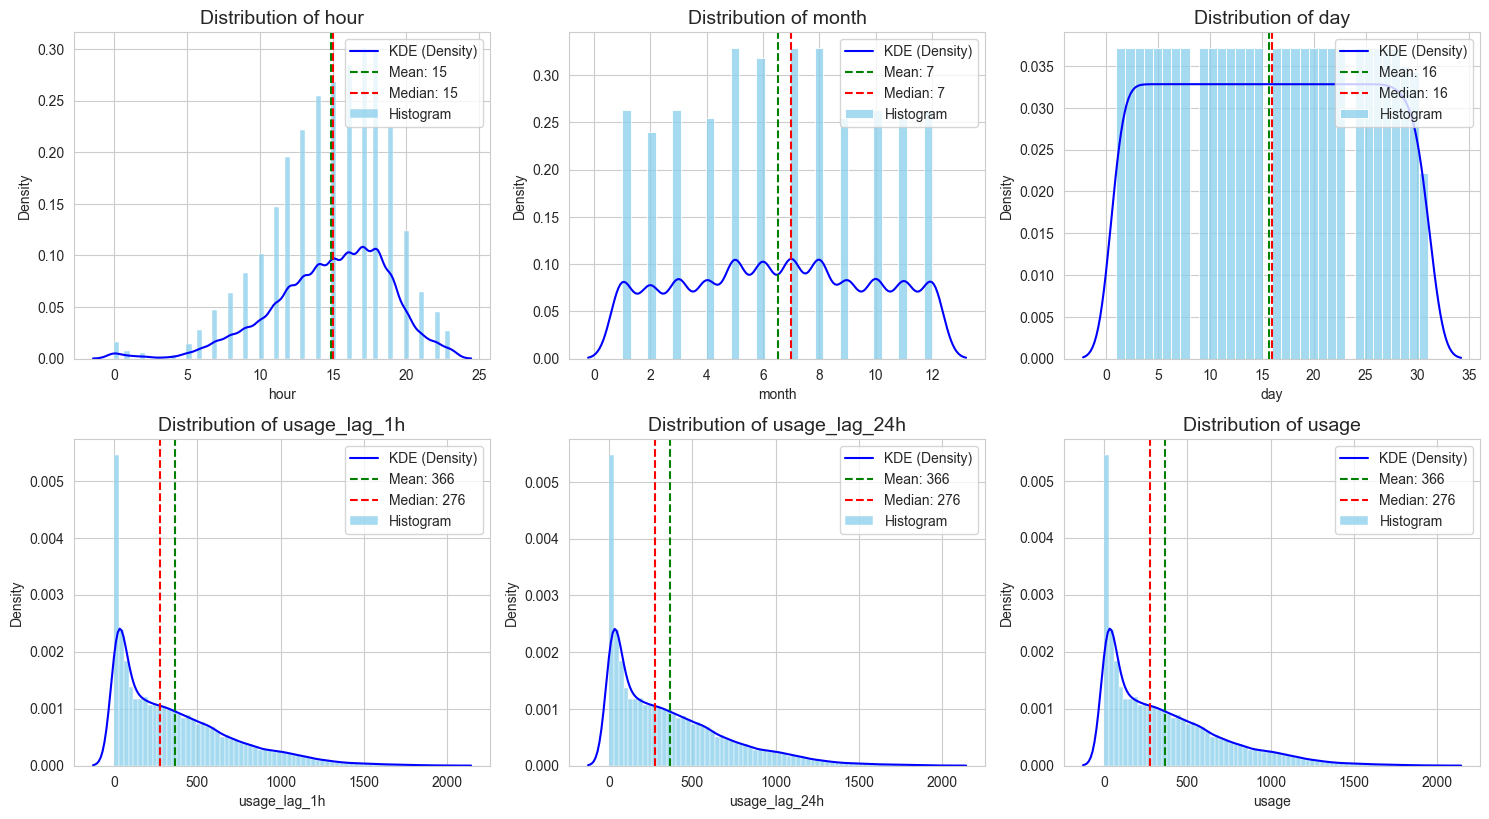

In [180]:
plotter.plot_distribution_histogram()

C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\958837352.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\958837352.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\958837352.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\958837352.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ig

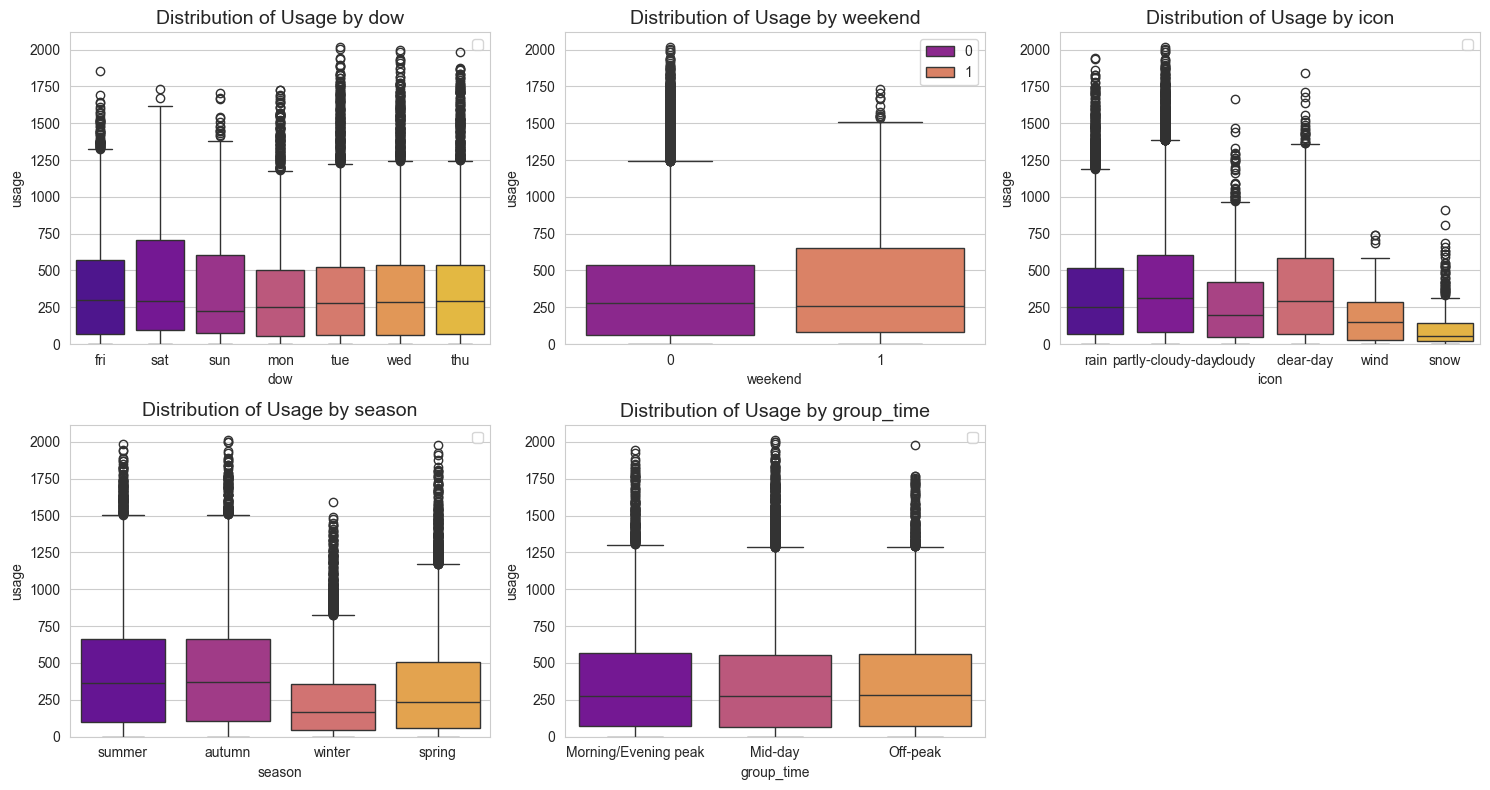

In [194]:
plotter.plot_categorical_boxplots()

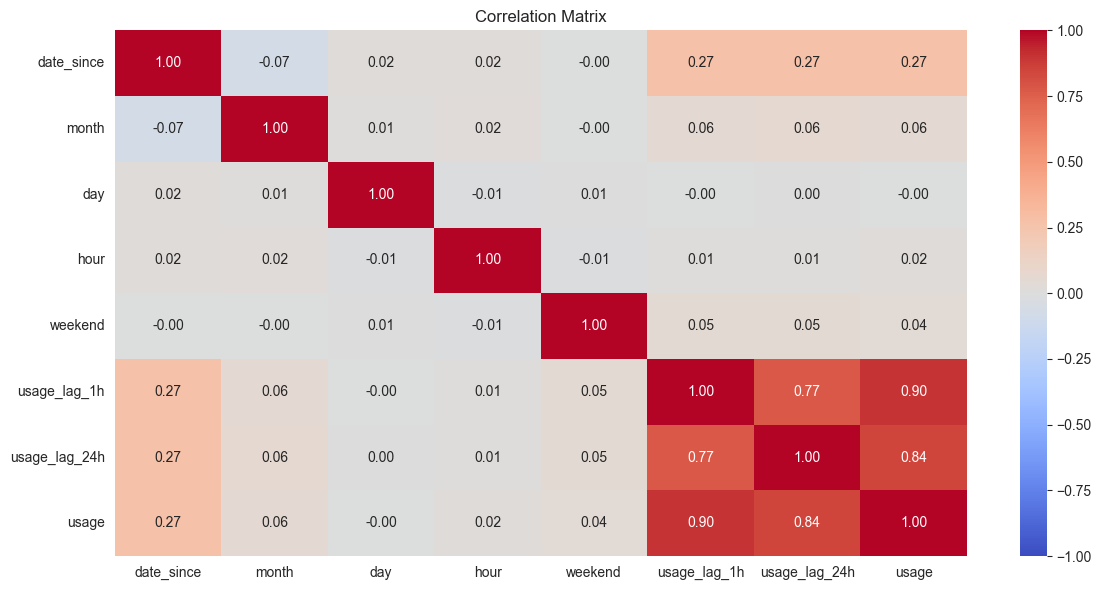

In [182]:
plotter.plot_correlation_matrix()

## Thống kê total_rental và Day of week

=== BẢNG THỐNG KÊ NHU CẦU THEO THỨ (DOW) ===
   dow  So_luong_mau  Tong_luot_thue  Trung_binh  Trung_vi  Do_lech_chuan  \
2  sat          5448       2280357.0  418.567731     296.0     377.580712   
0  fri          5448       1996181.0  366.406204     301.0     325.557622   
4  thu          5424       1976716.0  364.438791     293.0     350.698436   
6  wed          5424       1972921.0  363.739122     286.0     355.963023   
3  sun          5424       1968505.0  362.924963     228.0     347.391999   
5  tue          5424       1947218.0  359.000369     282.0     356.125515   
1  mon          5424       1786225.0  329.318768     252.0     317.846438   

   Cao_nhat  
2    1732.0  
0    1851.0  
4    1980.0  
6    1997.0  
3    1708.0  
5    2016.0  
1    1724.0  
------------------------------------------------------------


C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\3585760654.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='dow', y='usage', ax=ax[0], palette='viridis', estimator='mean', errorbar=None)
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\3585760654.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='dow', y='usage', ax=ax[1], palette='Set2')


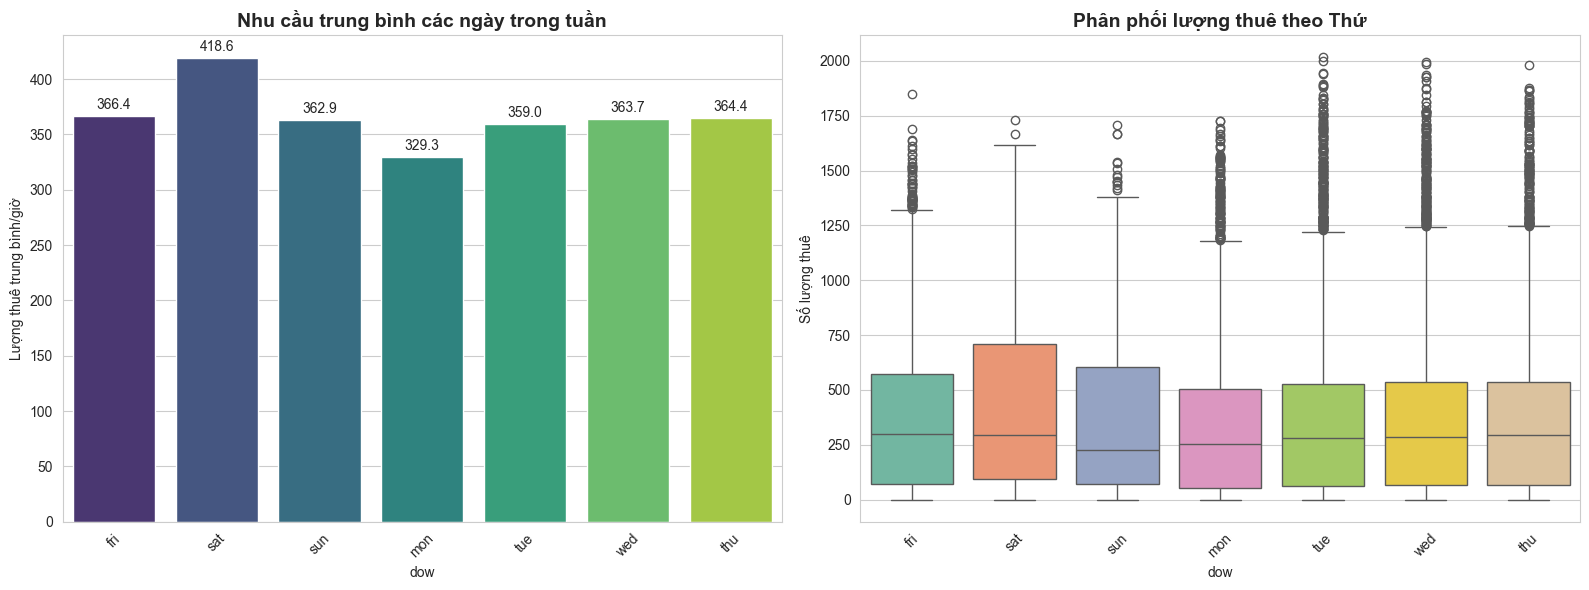

In [ ]:
#1.Prepare data 
df['usage'] = pd.to_numeric(df['usage'], errors='coerce').fillna(0)

# Define the correct order of days in a week
order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Check if the data in 'dow' matches the list above
unique_days = df['dow'].unique()
# If the data is in numbers (0-6) or different names, we will not force category type to avoid NaN errors
if set(unique_days).issubset(set(order_of_days)):
    df['dow'] = pd.Categorical(df['dow'], categories=order_of_days, ordered=True)

# 2. Compute detailed statistics table
stats_dow = df.groupby('dow')['usage'].agg(
    So_luong_mau=('count'),
    Tong_luot_thue=('sum'),
    Trung_binh=('mean'),
    Trung_vi=('median'),
    Do_lech_chuan=('std'),
    Cao_nhat=('max')
).reset_index() 


if not set(unique_days).issubset(set(order_of_days)):
    stats_dow = stats_dow.sort_values(by='Average', ascending=False)

print("=== Detailed Statistics Table by Day of Week (DOW) ===")
print(stats_dow)
print("-" * 60)

# 3. Plot diagrams (2 plots)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Barplot (Average)
sns.barplot(data=df, x='dow', y='usage', ax=ax[0], palette='viridis', estimator='mean', errorbar=None)
ax[0].set_title('Average demand by day of week', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Average rentals/hour')
ax[0].tick_params(axis='x', rotation=45) 

# Show numbers on top of bars
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.1f', padding=3, fontsize=10)

# Chart 2: Boxplot (Distribution)
sns.boxplot(data=df, x='dow', y='usage', ax=ax[1], palette='Set2')
ax[1].set_title('Distribution of rentals by day of week', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Number of rentals')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Thống kê total_rental và season 

=== BẢNG THỐNG KÊ NHU CẦU THEO MÙA ===
   season  So_luong_mau  Tong_luot_thue  Trung_binh  Trung_vi  Do_lech_chuan  \
0  autumn          9576       4161551.0  434.581349     368.0     371.691338   
1  spring          8568       2847739.0  332.369164     231.5     335.641677   
2  summer         11040       4811852.0  435.856159     366.5     375.177411   
3  winter          8832       2106981.0  238.562160     170.0     244.284112   

   Cao_nhat  
0    2016.0  
1    1980.0  
2    1985.0  
3    1590.0  
------------------------------------------------------------


C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\3177927952.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='season', y='usage', ax=ax[0], palette='Spectral', estimator='mean', errorbar=None)
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\3177927952.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='season', y='usage', ax=ax[1], palette='Spectral')


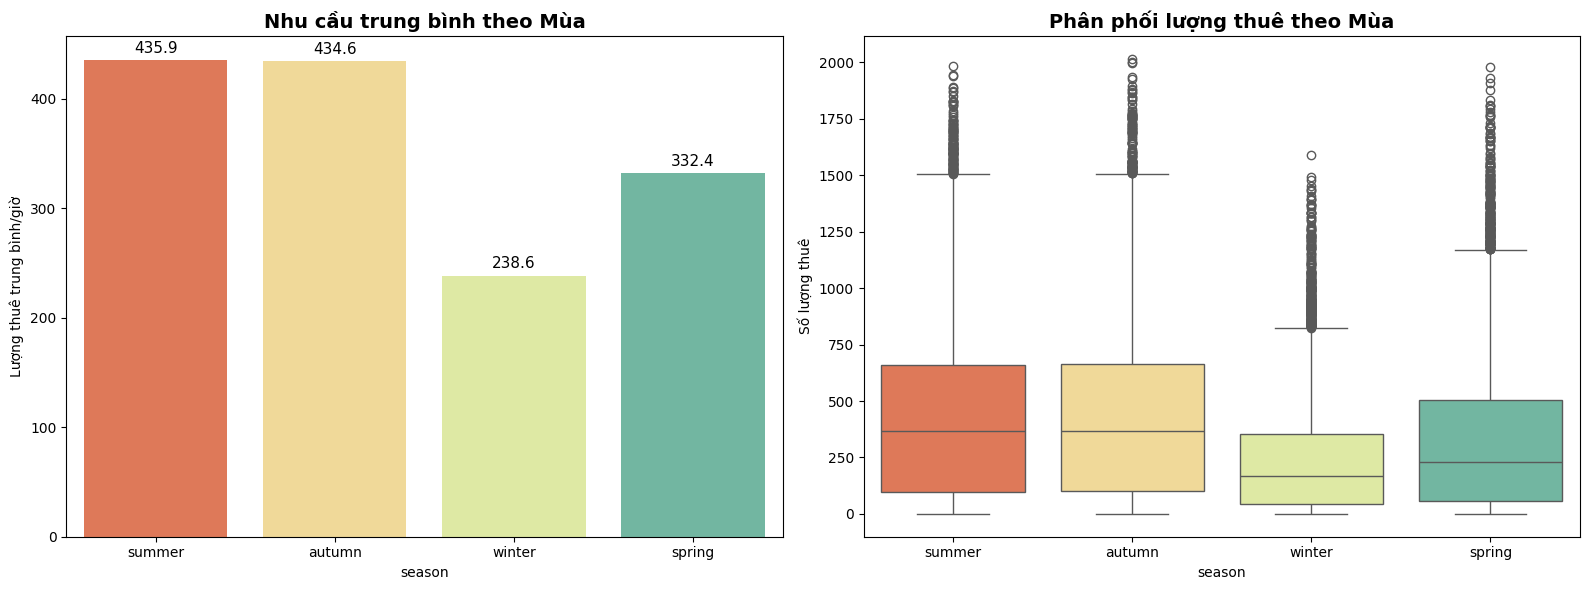

In [ ]:
# 1. Set the season order 
season_order = ['Spring', 'Summer', 'Fall', 'Winter']

# Check if the data uses the correct English names
# If the data uses numbers (1,2,3,4) or Vietnamese labels, the code will skip this ordering step
if set(df['season'].unique()).issubset(set(season_order)):
    df['season'] = pd.Categorical(df['season'], categories=season_order, ordered=True)

# 2. Compute detailed statistics table
stats_season = df.groupby('season')['usage'].agg(
    sample_count=('count'),
    total_rentals=('sum'),
    average=('mean'),
    median=('median'),
    std_deviation=('std'),
    max_rentals=('max')
).reset_index()

print("=== Detailed Statistics Table by Season ===")
print(stats_season)
print("-" * 60)

# 3. Plot diagrams (2 plots)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Barplot (Average)

sns.barplot(data=df, x='season', y='usage', ax=ax[0], palette='Spectral', estimator='mean', errorbar=None)
ax[0].set_title('Average demand by Season', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Average rentals/hour')

# Show numbers on top of bars
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.1f', padding=3, fontsize=11)

# Chart 2: Boxplot (Distribution)
sns.boxplot(data=df, x='season', y='usage', ax=ax[1], palette='Spectral')
ax[1].set_title('Distribution of rentals by Season', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Number of rentals')

plt.tight_layout()
plt.show()

## Thống kê total_rental và group_time

=== BẢNG THỐNG KÊ NHU CẦU THEO NHÓM GIỜ ===
             group_time  So_luong_mau  Tong_luot_thue  Trung_binh  Trung_vi  \
0               Mid-day         20907       7615241.0  364.243603     274.0   
1  Morning/Evening peak          9576       3544350.0  370.128446     278.0   
2              Off-peak          7533       2768532.0  367.520510     280.0   

   Do_lech_chuan  Cao_nhat  
0     349.720939    2016.0  
1     347.804833    1943.0  
2     346.705984    1980.0  
------------------------------------------------------------


C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\1047899214.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='group_time', y='usage', ax=ax[0], palette='Reds_r', estimator='mean', errorbar=None)
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\1047899214.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='group_time', y='usage', ax=ax[1], palette='Reds_r')


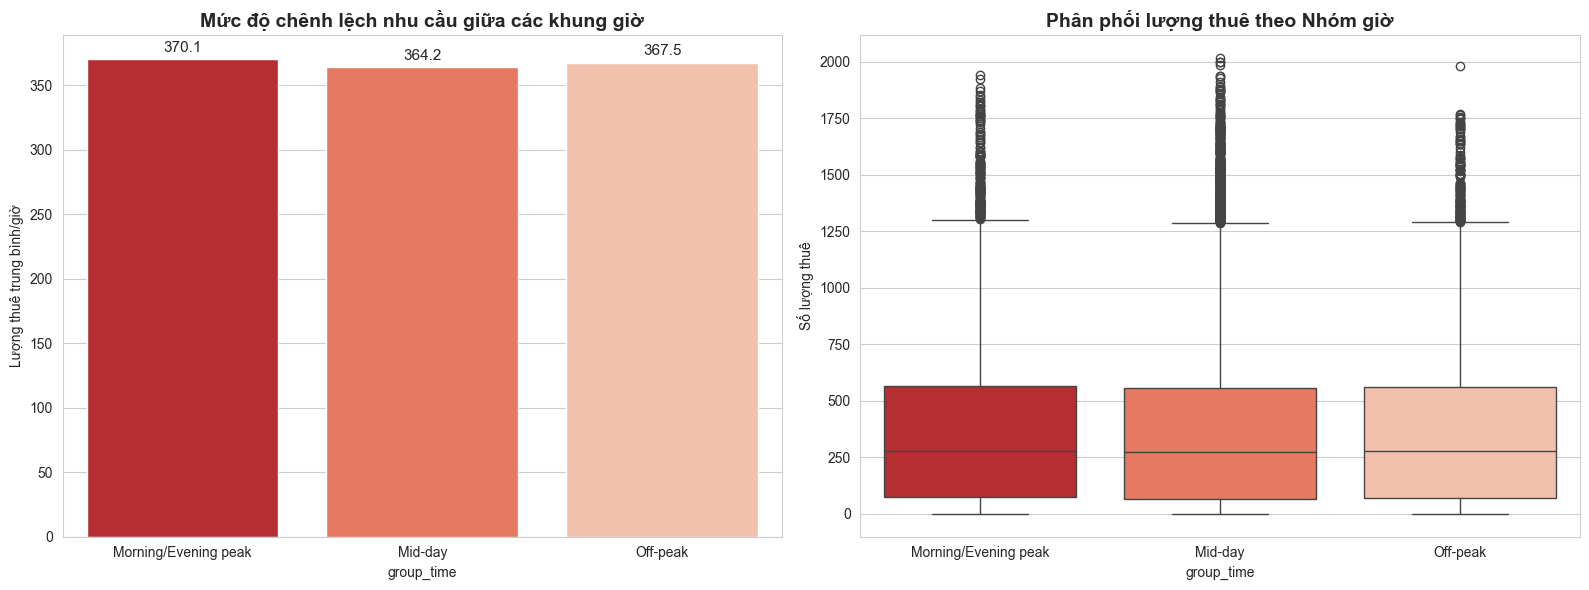

In [ ]:
# 1. THIẾT LẬP THỨ TỰ HIỂN THỊ (Logical Order)
# Sắp xếp từ quan trọng nhất đến ít quan trọng nhất
time_order = ['Giờ cao điểm', 'Giờ thường', 'Ngoài giờ']

# Kiểm tra xem dữ liệu có khớp tên không để ép kiểu
if set(df['group_time'].unique()).issubset(set(time_order)):
    df['group_time'] = pd.Categorical(df['group_time'], categories=time_order, ordered=True)

# 2. TÍNH BẢNG THỐNG KÊ CHI TIẾT
stats_time = df.groupby('group_time')['usage'].agg(
    So_luong_mau=('count'),
    Tong_luot_thue=('sum'),
    Trung_binh=('mean'),
    Trung_vi=('median'),
    Do_lech_chuan=('std'),
    Cao_nhat=('max')
).reset_index()

print("=== BẢNG THỐNG KÊ NHU CẦU THUÊ XE THEO NHÓM GIỜ ===")
print(stats_time)
print("-" * 60)

# 3. VẼ BIỂU ĐỒ (2 HÌNH)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Hình 1: Barplot (Trung bình)
# Dùng palette 'Reds_r' (Đỏ đậm -> Nhạt) để nhấn mạnh sự cấp thiết của Giờ cao điểm
sns.barplot(data=df, x='group_time', y='usage', ax=ax[0], palette='Reds_r', estimator='mean', errorbar=None)
ax[0].set_title('Mức độ chênh lệch nhu cầu giữa các khung giờ', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Lượng thuê trung bình/giờ')

# Hiện số lên đầu cột
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.1f', padding=3, fontsize=11)

# Hình 2: Boxplot (Phân phối)
sns.boxplot(data=df, x='group_time', y='usage', ax=ax[1], palette='Reds_r')
ax[1].set_title('Phân phối lượng thuê theo Nhóm giờ', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Số lượng thuê')

plt.tight_layout()
plt.show()

--- 1. PHÂN TÍCH ĐƠN BIẾN ---


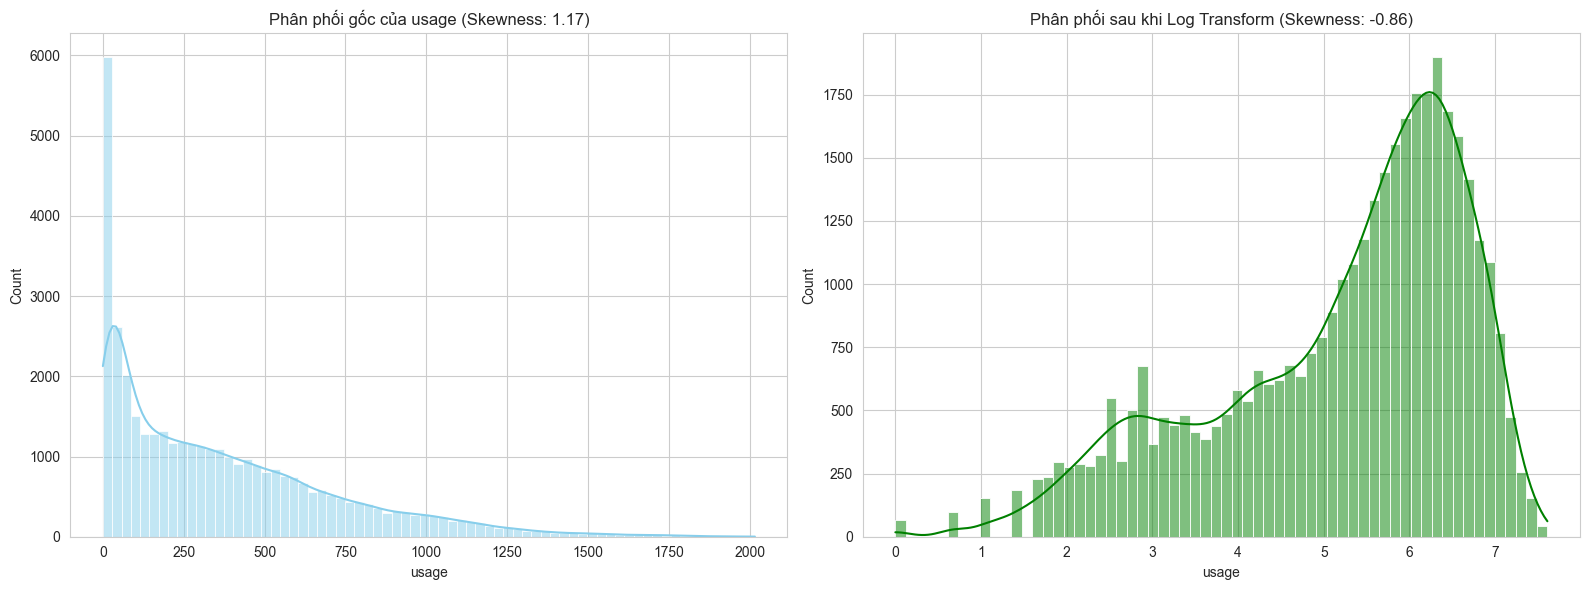

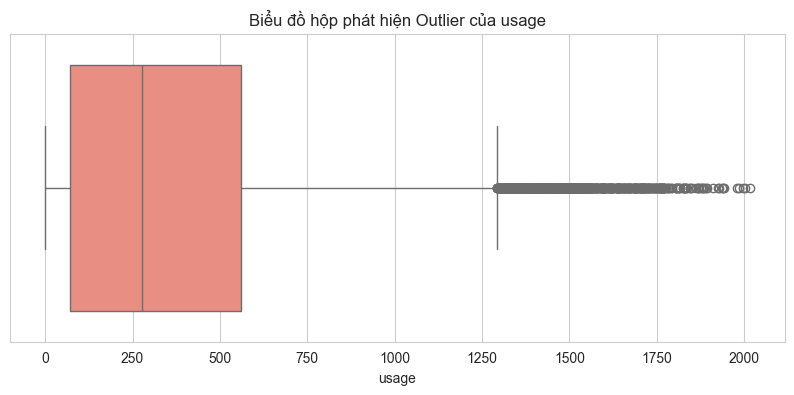

C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\315853822.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=axes[i], palette='Set2')
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\315853822.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, ax=axes[i], palette='Set2')


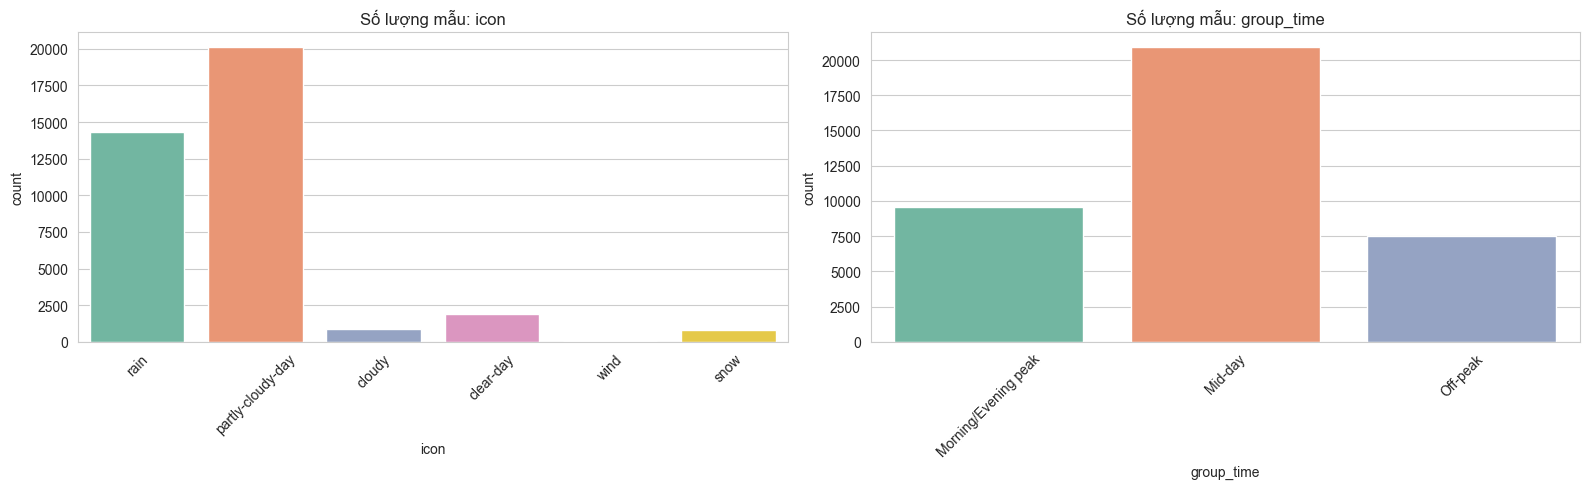

--- 2. PHÂN TÍCH HAI BIẾN (HÀNH VI & XU HƯỚNG) ---


C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\315853822.py:77: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='month', y=target_col, palette='viridis', ci=None)
C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\315853822.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='month', y=target_col, palette='viridis', ci=None)


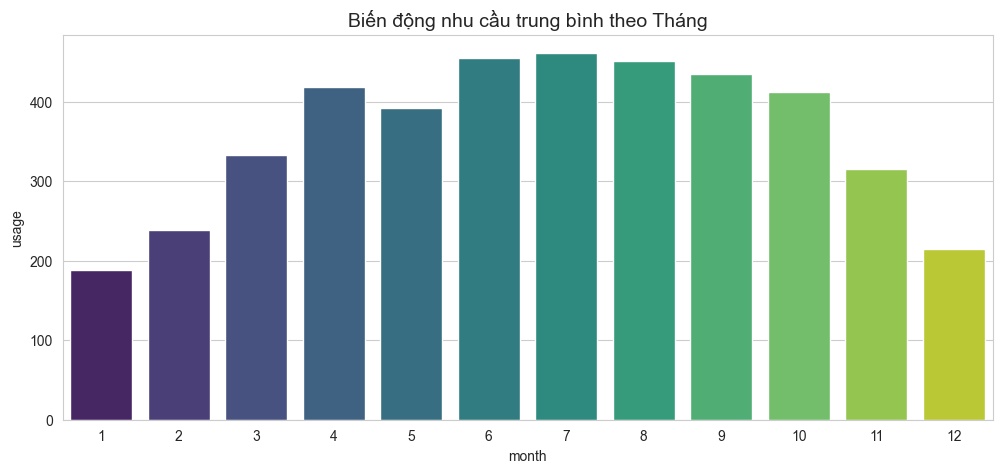

C:\Users\Hao Le\AppData\Local\Temp\ipykernel_29952\315853822.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='icon', y=target_col, order=order_icon, palette='coolwarm')


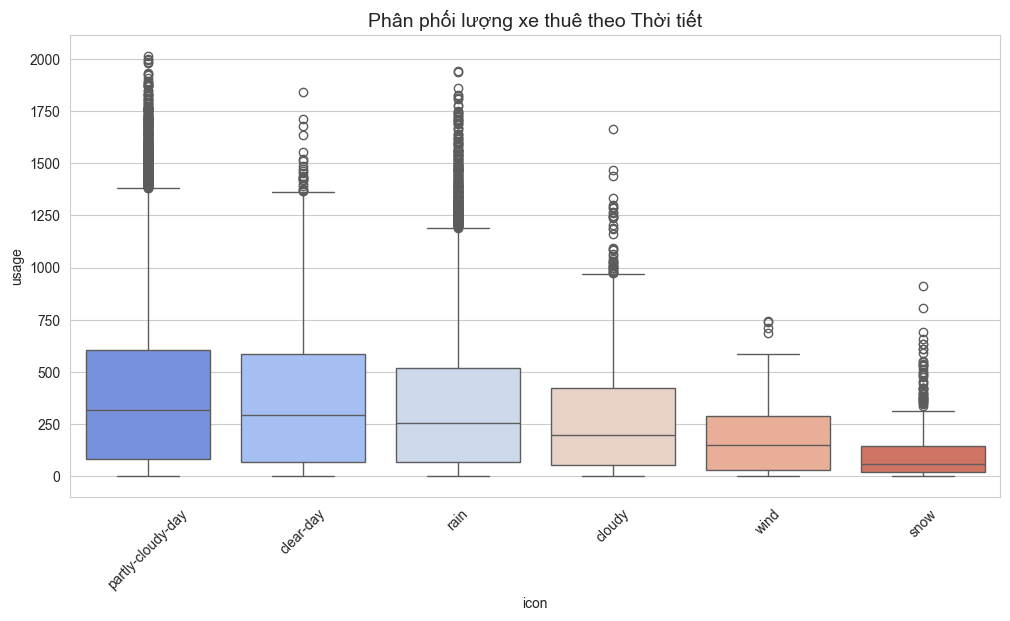

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- CẤU HÌNH BAN ĐẦU ---
sns.set_style("whitegrid") # Giao diện nền trắng kẻ lưới
plt.rcParams['figure.figsize'] = (12, 6) # Kích thước mặc định

# QUAN TRỌNG: Đặt tên biến mục tiêu bạn muốn phân tích ở đây
target_col = 'usage'  

# Kiểm tra xem cột có tồn tại không để tránh lỗi
if target_col not in df.columns:
    print(f"Cảnh báo: Không thấy cột '{target_col}'. Đang dùng cột đầu tiên dạng số để thay thế demo.")
    target_col = df.select_dtypes(include=np.number).columns[0]


# ==============================================================================
# PHẦN 1: PHÂN TÍCH ĐƠN BIẾN (UNIVARIATE ANALYSIS)
# Mục tiêu: Kiểm tra độ chuẩn (Normality) và độ cân bằng dữ liệu
# ==============================================================================
print("--- 1. PHÂN TÍCH ĐƠN BIẾN ---")

# 1.1. Kiểm tra phân phối của biến mục tiêu (Histogram & KDE)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ gốc
sns.histplot(df[target_col], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title(f'Phân phối gốc của {target_col} (Skewness: {df[target_col].skew():.2f})')

# Biểu đồ sau khi Log Transform (Để kiểm tra xem có chuẩn hơn không)
# np.log1p là log(x+1) để tránh lỗi số 0
sns.histplot(np.log1p(df[target_col]), kde=True, ax=axes[1], color='green')
axes[1].set_title(f'Phân phối sau khi Log Transform (Skewness: {np.log1p(df[target_col]).skew():.2f})')

plt.tight_layout()
plt.show()

# 1.2. Kiểm tra Outlier (Boxplot)
plt.figure(figsize=(10, 4))
sns.boxplot(x=df[target_col], color='salmon')
plt.title(f'Biểu đồ hộp phát hiện Outlier của {target_col}')
plt.show()

# 1.3. Kiểm tra độ cân bằng của các biến phân loại (Categorical Balance)
cols_cat = ['icon', 'day_type', 'group_time'] # Các cột chữ cần kiểm tra
cols_cat = [c for c in cols_cat if c in df.columns]

if cols_cat:
    fig, axes = plt.subplots(1, len(cols_cat), figsize=(16, 5))
    if len(cols_cat) == 1: axes = [axes] # Xử lý trường hợp chỉ có 1 cột
    
    for i, col in enumerate(cols_cat):
        sns.countplot(data=df, x=col, ax=axes[i], palette='Set2')
        axes[i].set_title(f'Số lượng mẫu: {col}')
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# ==============================================================================
# PHẦN 2: PHÂN TÍCH HAI BIẾN (BIVARIATE ANALYSIS) - TRẢ LỜI RQ2
# Mục tiêu: Tìm hiểu hành vi khách hàng theo thời gian và ngoại cảnh
# ==============================================================================
print("--- 2. PHÂN TÍCH HAI BIẾN (HÀNH VI & XU HƯỚNG) ---")

# 2.1. Xu hướng theo Tháng (Tính mùa vụ)
# Tạo cột tháng nếu chưa có
if 'month' not in df.columns and 'datetime' in df.columns:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['month'] = df['datetime'].dt.month

if 'month' in df.columns:
    plt.figure(figsize=(12, 5))
    sns.barplot(data=df, x='month', y=target_col, palette='viridis', ci=None)
    plt.title('Biến động nhu cầu trung bình theo Tháng', fontsize=14)
    plt.show()

# 2.2. Tác động của Thời tiết (Boxplot)
if 'icon' in df.columns:
    plt.figure(figsize=(12, 6))
    # Sắp xếp theo trung bình giảm dần để dễ nhìn
    order_icon = df.groupby('icon')[target_col].mean().sort_values(ascending=False).index
    sns.boxplot(data=df, x='icon', y=target_col, order=order_icon, palette='coolwarm')
    plt.title('Phân phối lượng xe thuê theo Thời tiết', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()



# 6. Data Pre-processing

In [198]:
df = pd.read_csv("../data/processed/dataset.csv")
df.head()

,date_since,month,day,hour,dow,weekend,season,icon,usage_lag_1h,usage_lag_24h,usage,group_time
0,0,5,1,17,fri,0,summer,rain,0.0,0.0,9.0,Morning/Evening peak
1,0,5,1,14,fri,0,summer,rain,9.0,0.0,0.0,Mid-day
2,0,5,1,17,fri,0,summer,rain,0.0,0.0,4.0,Morning/Evening peak
3,0,5,1,15,fri,0,summer,rain,4.0,0.0,1.0,Mid-day
4,0,5,1,14,fri,0,summer,rain,1.0,0.0,4.0,Mid-day


In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38016 entries, 0 to 38015
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date_since     38016 non-null  int64  
 1   month          38016 non-null  int64  
 2   day            38016 non-null  int64  
 3   hour           38016 non-null  int64  
 4   dow            38016 non-null  object 
 5   weekend        38016 non-null  int64  
 6   season         38016 non-null  object 
 7   icon           38016 non-null  object 
 8   usage_lag_1h   38016 non-null  float64
 9   usage_lag_24h  38016 non-null  float64
 10  usage          38016 non-null  float64
 11  group_time     38016 non-null  object 
dtypes: float64(3), int64(5), object(4)
memory usage: 3.5+ MB


In [205]:
df.describe()

,date_since,month,day,hour,weekend,usage_lag_1h,usage_lag_24h,usage
count,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000,38016.000000
mean,791.500000,6.521465,15.741162,14.881155,0.285985,366.368003,365.979877,366.375289
std,457.267336,3.326862,8.806316,3.955098,0.451888,348.647777,348.518849,348.643015
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,395.750000,4.000000,8.000000,12.000000,0.000000,70.000000,69.000000,70.000000
50%,791.500000,7.000000,16.000000,15.000000,0.000000,276.000000,276.000000,276.000000
75%,1187.250000,9.000000,23.000000,18.000000,1.000000,559.000000,559.000000,559.000000
max,1583.000000,12.000000,31.000000,23.000000,1.000000,2016.000000,2016.000000,2016.000000


In [206]:
y = df["usage"]
X = df.drop(columns="usage")

# 7.Xây dựng & Huấn luyện Model

In [ ]:
from sklearn.model_selection import train_test_split

# --- STEP 1: SPLIT DATA INTO (TRAIN + VALID) AND (TEST) ---
# We reserve 20% of the total dataset for the final testing phase.
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# --- STEP 2: SPLIT (TRAIN + VALID) INTO (TRAIN) AND (VALID) ---
# By taking 25% of the remaining 80%, we allocate exactly 20% of the 
# original total data to the Validation set.
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=0.25, random_state=42, shuffle=True
)

# Final verification of dataset sizes
print(f"Train size: {len(X_train)} | Valid size: {len(X_valid)} | Test size: {len(X_test)}")

Train size: 22809 | Valid size: 7603 | Test size: 7604


: 

In [220]:
def pred_at_x(y_true, y_pred, x=0.25, eps=1e-8):
            """
            PRED(x) = tỷ lệ mẫu có |y-ŷ|/max(|y|,eps) <= x
            Trả về giá trị [0,1]. (nhân 100 nếu muốn %)
            """
            y_true = np.asarray(y_true)
            y_pred = np.asarray(y_pred)

            denom = np.maximum(np.abs(y_true), eps)     # tránh chia 0 khi y_true=0
            are = np.abs(y_true - y_pred) / denom       # absolute relative error
            return np.mean(are <= x)


>>> RUNNING VALIDATION PHASE <<<


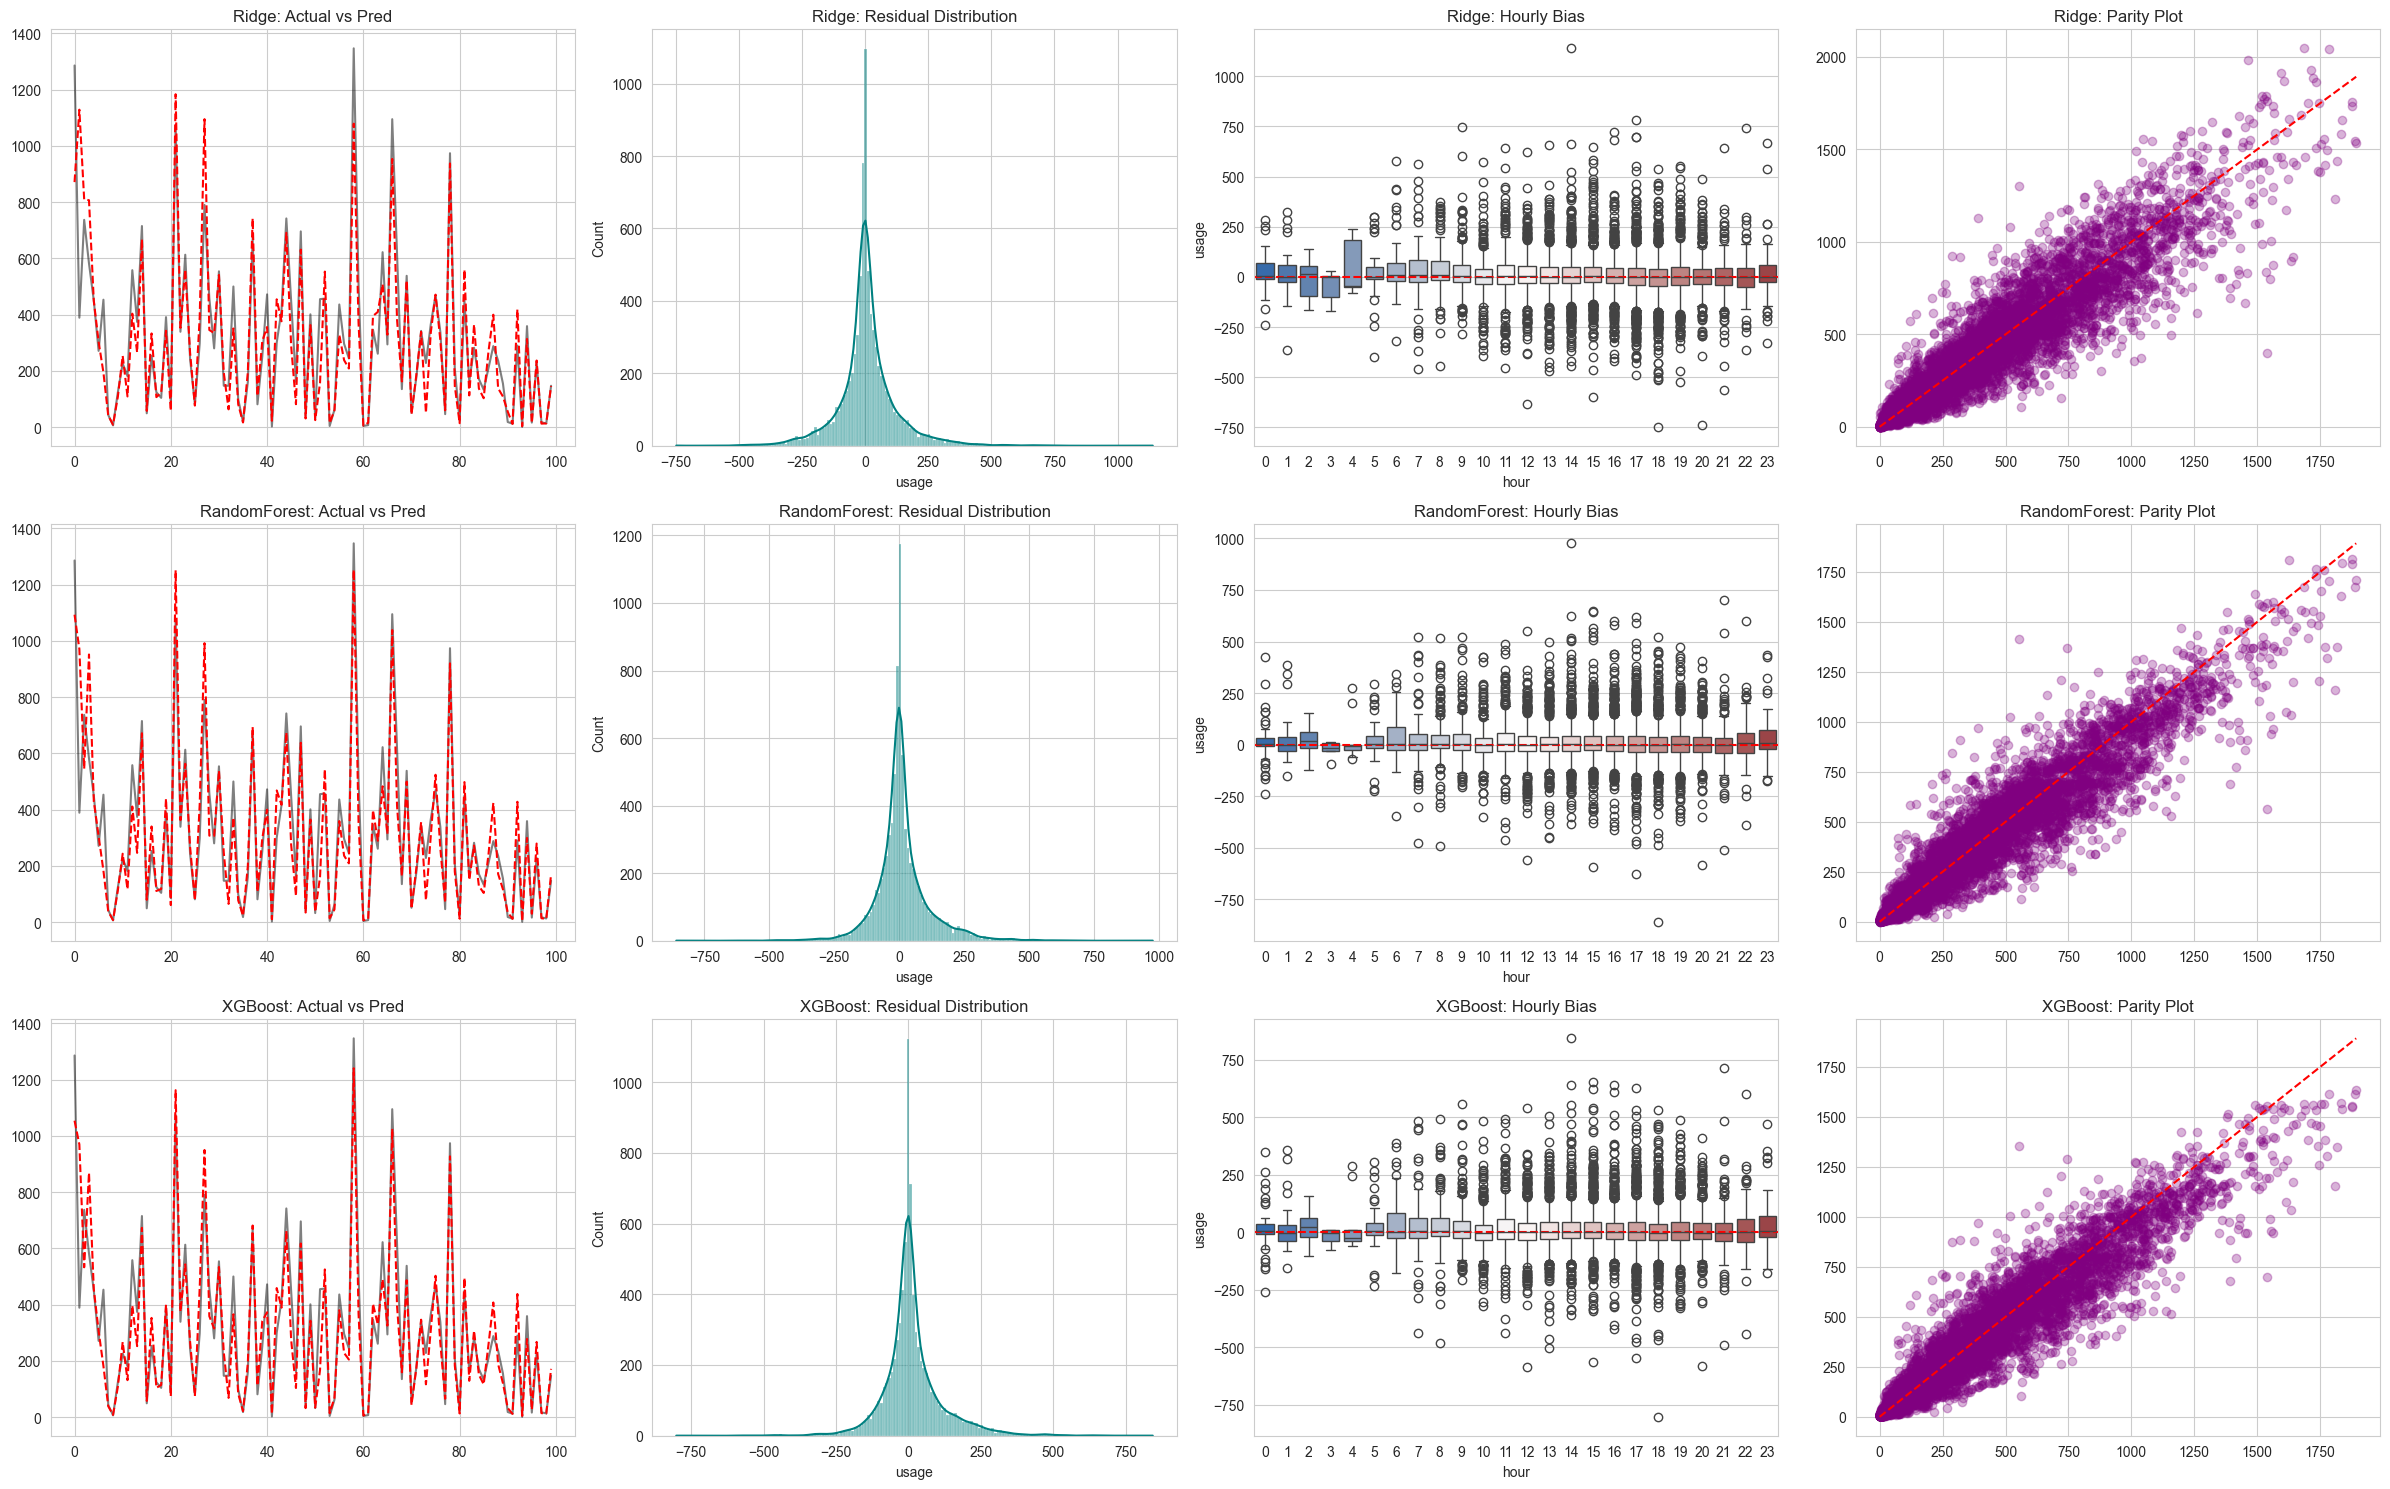

Validation Leaderboard:
          Model  WAPE (%)    MAE    RMSE      R2  PRED(0.25) (%)
2       XGBoost     18.22  65.44  105.21  0.9360           62.10
1  RandomForest     18.25  65.55  105.57  0.9346           61.85
0         Ridge     20.84  74.83  119.21  0.9237           57.12


In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

# --- STEP 1: DEFINE PREPROCESSING PIPELINE ---
categorical_features = ["dow", "icon", "weekend", "season", "group_time"] 
numeric_features = ["date_since", "hour", "day", "month"]
lag_features = ["usage_lag_1h", "usage_lag_24h"]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        # Fix: feature_names_out avoids AttributeError
        ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one'), lag_features),
        ('num', 'passthrough', numeric_features)
    ]
)

feature_processing_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

# --- STEP 2: REUSABLE EVALUATION & PLOTTING ENGINE ---
def pred_at_x(y_true, y_pred, x=0.25, eps=1e-8):
    """
    PRED(x) = tỷ lệ mẫu có |y-ŷ|/max(|y|,eps) <= x
    Trả về [0,1]. Nếu muốn %, nhân 100.
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    denom = np.maximum(np.abs(y_true), eps)  # tránh chia 0 nếu y_true=0
    are = np.abs(y_true - y_pred) / denom
    return np.mean(are <= x)

def evaluate_and_plot(models_dict, X_train, y_train, X_eval, y_eval, feature_pipeline, stage_name):
    """
    Fits models on training data, predicts on evaluation data, 
    calculates metrics, and generates 4 diagnostic plots per model.
    """
    results = []
    num_models = len(models_dict)
    fig, axes = plt.subplots(num_models, 4, figsize=(24, 5 * num_models))
    if num_models == 1: axes = np.expand_dims(axes, axis=0)

    print(f"\n>>> RUNNING {stage_name.upper()} PHASE <<<")
    
    for idx, (name, model) in enumerate(models_dict.items()):
        # Create full pipeline with automatic target log-transformation
        full_pipeline = Pipeline([
            ('features', feature_pipeline),
            ('model', TransformedTargetRegressor(regressor=model, func=np.log1p, inverse_func=np.expm1))
        ])
        
        # Train model
        full_pipeline.fit(X_train, y_train)
        
        # Predict on evaluation set (Validation or Test)
        y_pred = full_pipeline.predict(X_eval)
        residuals = y_eval - y_pred

        # Metrics
        rmse = np.sqrt(mean_squared_error(y_eval, y_pred))
        mae = mean_absolute_error(y_eval, y_pred)
        wape = (np.sum(np.abs(residuals)) / np.sum(y_eval)) * 100
        r2 = r2_score(np.log1p(y_eval), np.log1p(y_pred))
        
        pred25 = pred_at_x(y_eval, y_pred, x=0.25) * 100
        
        results.append({
            "Model": name, "WAPE (%)": round(wape, 2), 
            "MAE": round(mae, 2), "RMSE": round(rmse, 2), "R2": round(r2, 4), "PRED(0.25) (%)": round(pred25, 2)
        })

        # Visualization
        axes[idx, 0].plot(y_eval.values[:100], label='Actual', color='black', alpha=0.5)
        axes[idx, 0].plot(y_pred[:100], label='Predicted', color='red', linestyle='--')
        axes[idx, 0].set_title(f'{name}: Actual vs Pred')
        
        sns.histplot(residuals, kde=True, ax=axes[idx, 1], color='teal')
        axes[idx, 1].set_title(f'{name}: Residual Distribution')

        sns.boxplot(x=X_eval['hour'], y=residuals, ax=axes[idx, 2], hue=X_eval['hour'], palette="vlag", legend=False)
        axes[idx, 2].axhline(0, color='red', linestyle='--')
        axes[idx, 2].set_title(f'{name}: Hourly Bias')

        axes[idx, 3].scatter(y_eval, y_pred, alpha=0.3, color='purple')
        axes[idx, 3].plot([y_eval.min(), y_eval.max()], [y_eval.min(), y_eval.max()], 'r--')
        axes[idx, 3].set_title(f'{name}: Parity Plot')

    plt.tight_layout()
    plt.show()
    return pd.DataFrame(results).sort_values(by="WAPE (%)"), full_pipeline # returns df and last trained pipeline

# --- STEP 3: PHASE 1 - VALIDATION & TUNING ---
# Define models for initial selection
candidate_models = {
    "Ridge": Ridge(alpha=10.0), # Increased alpha to avoid overflow
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=10, n_jobs=-1, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=42)
}

# Run on Validation Set
# You repeat this step as many times as needed to tune your parameters
df_valid_results, _ = evaluate_and_plot(
    candidate_models, X_train, y_train, X_valid, y_valid, 
    feature_processing_pipeline, stage_name="Validation"
)
print("Validation Leaderboard:")
print(df_valid_results)


>>> RUNNING FINAL TEST PHASE <<<


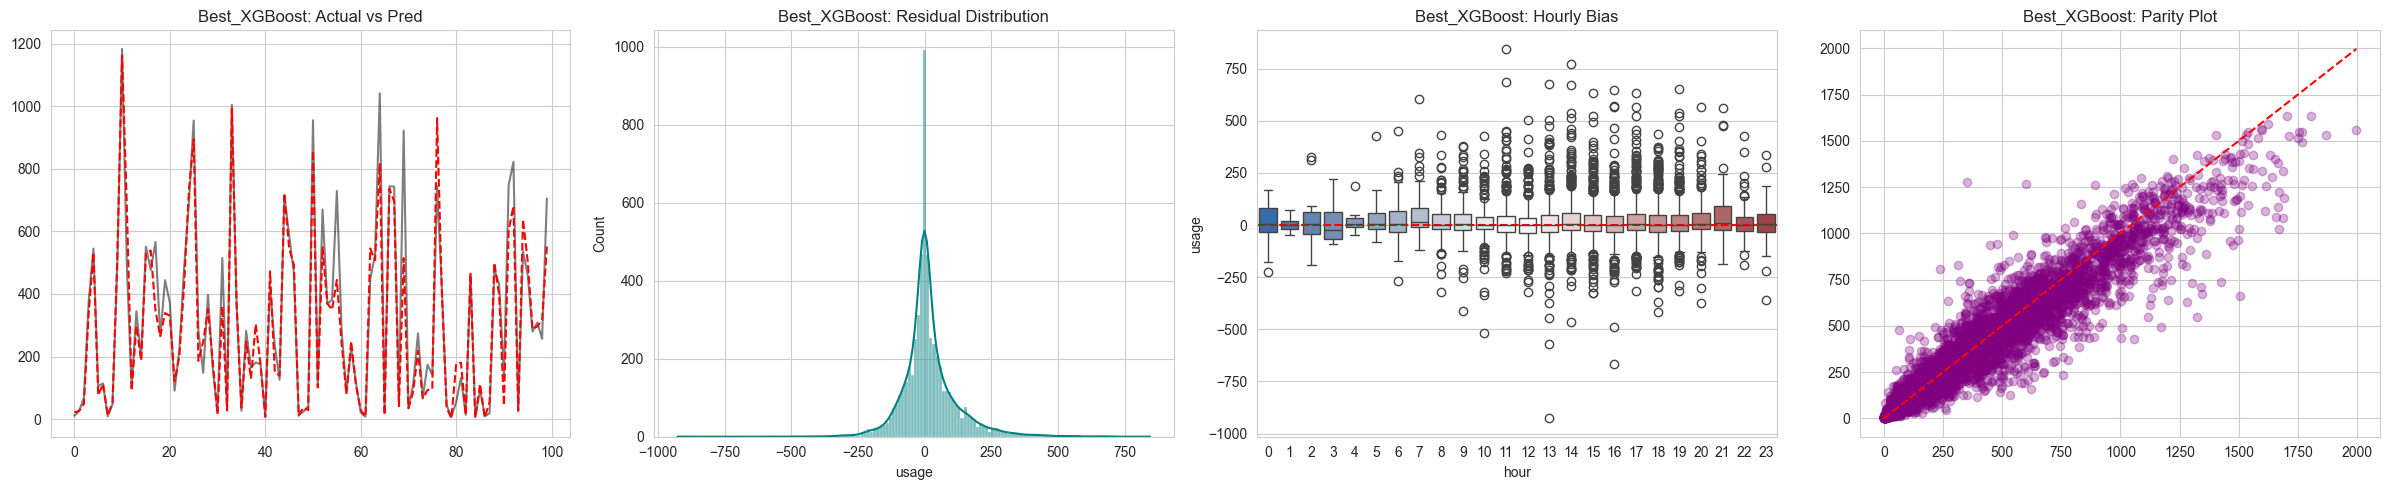


Final Test Leaderboard:
          Model  WAPE (%)    MAE    RMSE      R2  PRED(0.25) (%)
0  Best_XGBoost     17.91  66.86  108.09  0.9386            62.7


In [222]:
# --- STEP 4: PHASE 2 - FINAL TEST ---
# Once you are satisfied with your tuning, run this final block ONCE.
# Optionally, you can retrain the best model on (Train + Valid) for the final test.
final_models = {
    "Best_XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1, random_state=42)
}

df_test_results, best_pipeline = evaluate_and_plot(
    final_models, X_train, y_train, X_test, y_test, 
    feature_processing_pipeline, stage_name="Final Test"
)
print("\nFinal Test Leaderboard:")
print(df_test_results)